<a href="https://colab.research.google.com/github/RohitBit-25/Al-ml-Colab/blob/main/lstm_Google_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0153 - val_loss: 0.0022
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 9.7713e-04 - val_loss: 0.0019
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 7.3438e-04 - val_loss: 0.0011
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 6.1245e-04 - val_loss: 0.0010
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 6.2362e-04 - val_loss: 0.0015
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 5.3931e-04 - val_loss: 9.5574e-04
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 5.3234e-04 - val_loss: 9.5750e-04
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 5.6681e-04 - val_loss: 9.2827e-04
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 4.4086e-04 - val_loss: 8.8613e-04
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 4.2168e-04 - val_loss: 8.4462e-04
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 4.8568e-04 - val_loss: 0.0019
Ep

[*********************100%***********************]  1 of 1 completed


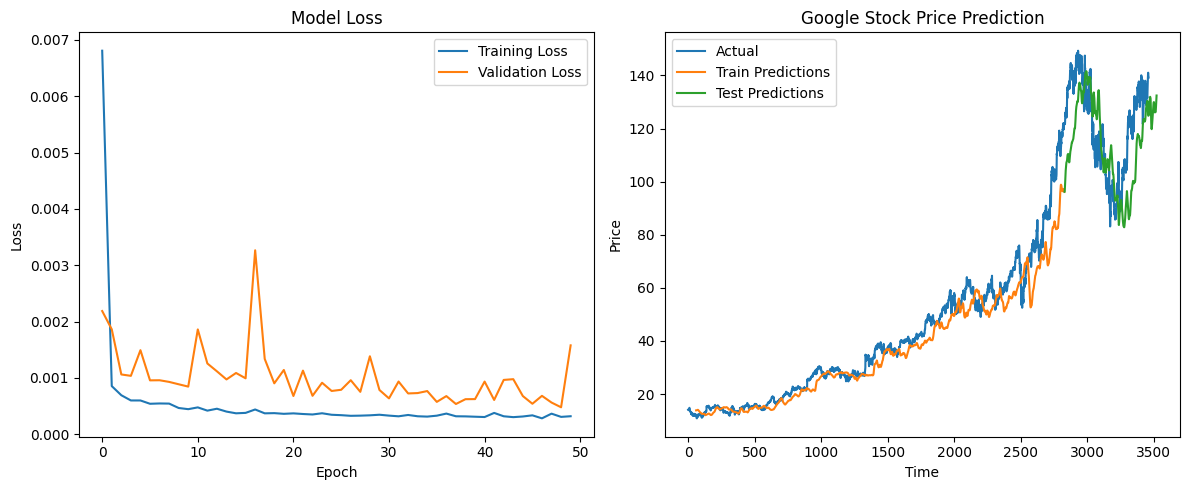

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def prepare_google_data():
    """
    Download and prepare Google stock data
    """
    # Download Google stock data
    google = yf.download('GOOGL', start='2010-01-01', end='2024-01-01')

    # Select 'Close' prices
    data = google['Close'].values.reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler, data

def create_sequences(data, seq_length):
    """
    Create sequences for LSTM input
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def build_lstm_model(seq_length):
    """
    Build LSTM model architecture
    """
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def train_and_evaluate_model():
    # Step 1: Prepare data
    scaled_data, scaler, raw_data = prepare_google_data()

    # Step 2: Define parameters
    seq_length = 60  # Number of time steps
    split_ratio = 0.8

    # Step 3: Create sequences
    X, y = create_sequences(scaled_data, seq_length)

    # Step 4: Split into train and test sets
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Step 5: Build and train model
    model = build_lstm_model(seq_length)
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )

    # Step 6: Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Step 7: Inverse transform predictions
    train_predict = scaler.inverse_transform(train_predict)
    y_train_inv = scaler.inverse_transform(y_train)
    test_predict = scaler.inverse_transform(test_predict)
    y_test_inv = scaler.inverse_transform(y_test)

    # Step 8: Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
    test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
    train_mae = mean_absolute_error(y_train_inv, train_predict)
    test_mae = mean_absolute_error(y_test_inv, test_predict)

    return {
        'model': model,
        'history': history,
        'metrics': {
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae
        },
        'predictions': {
            'train': train_predict,
            'test': test_predict
        }
    }

def plot_results(history, predictions, raw_data, seq_length):
    """
    Plot training history and predictions
    """
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot predictions
    plt.subplot(1, 2, 2)
    plt.plot(raw_data[seq_length:], label='Actual')
    train_size = len(predictions['train'])
    plt.plot(range(seq_length, seq_length + train_size),
             predictions['train'], label='Train Predictions')
    plt.plot(range(seq_length + train_size, seq_length + train_size + len(predictions['test'])),
             predictions['test'], label='Test Predictions')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the entire process
if __name__ == "__main__":
    results = train_and_evaluate_model()
    print("\nModel Performance Metrics:")
    print(f"Training RMSE: ${results['metrics']['train_rmse']:.2f}")
    print(f"Testing RMSE: ${results['metrics']['test_rmse']:.2f}")
    print(f"Training MAE: ${results['metrics']['train_mae']:.2f}")
    print(f"Testing MAE: ${results['metrics']['test_mae']:.2f}")

    # Plot results
    plot_results(results['history'],
                results['predictions'],
                prepare_google_data()[2],
                60)